# Boston Housing Price Prediction

In [1]:
# Imports of libraries
# essential utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
# Models (linear and tree)
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
# custom function imports
from src.handle_data import get_data, split_data, merge_data, preprocess_data
from src.modelling import mean_std_cross_val_scores, fit_model, get_metrics, ols_coefficients
from src.plotting import eda_plot, plot_alpha_metrics, visualize_lr

## Introduction

Boston, a thriving metropolitan city known for its rich history and cultural significance, has grappled with the challenge of crime rate and its potential impact on housing prices. Drawing on a comprehensive set of variables, including not only structural characteristics of the housing but also hedonic variables such as crime occurrences in the neighborhood, tourism factor as Charles River and lower status of the population, we seek to provide insights into how these variables impacts housing prices in Boston, and to what extent it influences the dynamics of the local real estate market. In this project, we will use the [Boston Housing dataset](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data) to solve a prediction question. This dataset contains information on various attributes such as crime rate, average number of rooms, accessibility to highways, and more, which are hypothesized to influence housing prices. The project will involve several parts, including data cleaning, visualization, and model building. Our objective is to conduct exploratory data analysis (EDA) and then build a hedonic regression model with multiple inputs. We will utilize various Python techniques learned in this course to explore the real world data and solve economic questions.

By analyzing the data, we aim to answer economic questions related to the housing market and explore the real-world application of Python techniques. It is important to note that the dataset has its limitations as it was collected almost 50 years ago, but it still provides an excellent opportunity for us to apply our Python skills and gain insights of housing market.

### Dataset Description

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston, MA. The following describes the dataset columns:

- `CRIM` - per capita crime rate by town
- `ZN` - proportion of residential land zoned for lots over 25,000 sq.ft.
- `INDUS` - proportion of non-retail business acres per town.
- `CHAS` - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- `NOX` - nitric oxides concentration (parts per 10 million)
- `RM` - average number of rooms per dwelling
- `AGE` - proportion of owner-occupied units built prior to 1940
- `DIS` - weighted distances to five Boston employment centres
- `RAD` - index of accessibility to radial highways
- `TAX` - full-value property-tax rate per $10,000$
- `PTRATIO` - pupil-teacher ratio by town
- $B - 1000(Bk - 0.63)^2$ where $B_k$ is the proportion of blacks by town
- `LSTAT` - $%$ lower status of the population
- `MEDV` - Median value of owner-occupied homes in $1000$'s

Housing is a heterogeneous good, which comprises a collection of attributes, and its price is determined by the implicit prices of those attributes. The attributes that determine the price of housing can be broadly classified into three groups: site characteristics, neighborhood characteristics, and environmental characteristics. 

- The site characteristics include： `ZN`、`RM`、`AGE`、`TAX`、`MEDV`
- The neighborhood characteristics include：`CRIM`、`INDUS`、`CHAS`、`DIS`、`RAD` 、`PTRATIO`、`LSTAT`、`B`
- The environmental characteristics include：`NOX`

The dataset is derived from https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data.

## Methods

This report strives to be trustworthy using the following steps: 

1. [Thorough EDA](#eda)
2. [Model fitting](#model-fitting)
3. [Model selection](#model-selection)

During this project, we utilized GitHub for collaborative work. In order to improve readability, we created 10+ helper functions and stored them in three Python scripts in a folder named `src`. Therefore, in this notebook, our code is usually concise, such as the functions `eda_plot` and `fit_model`. These complicated helper functions we defined can demonstrate our group's strong coding abilities. If the grading team wishes to view these complicated helper functions, they can be found in the additional Python scripts we submitted, or in the GitHub as well. Here is the GitHub link of our project: https://github.com/tonyliang19/econ323_final_project


### EDA

During the EDA phrase, we will conduct a thorough examination of the Boston Housing dataset. One of the key steps is to generate a correlation matrix, which can help us identify any potential issues related to multicollinearity between the independent variables. In addition, we will use side-by-side box plots to visualize the distributions of the continuous variables and detect any potential outliers or anomalies. Moreover, we will leverage other data visualization techniques, such as scatter plots and histograms, to better understand the relationships between the variables and explore potential trends or patterns in the data. Overall, the goal of EDA is to gain insights into the data and inform our subsequent modelling steps. 

In [2]:
# read in the dataset
data_path = 'data/boston_housing_data.csv'
boston = get_data(data_path=data_path)
# prints size of the data
print(f"The Boston dataset has {boston.shape[0]} Observations and {boston.shape[1]} Variables")
# check the first 5 rows of the dataset
boston.head()

The Boston dataset has 506 Observations and 14 Variables


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


The Boston has in total 506 observations (not excluding null if any) and 14 variables. Upon observing the first 5 rows of the data, we can identify the types of variables. Although most of the features are numeric, there are still some special variables. For instance, the `CHAS` variable is a dummy variable indicating whether the tract bounds the Charles River or not, and it is encoded as 0 or 1. Additionally, the `RAD` variable is an indexed variable that may be dropped in the future analysis. Now, let's check if the data contains any null/missing observations.

In [3]:
# checks NA in data
nulls = boston[boston.isnull().any(axis=1)]
print(f"The Boston dataset has {nulls.shape[0]} rows that contains NaN")

The Boston dataset has 112 rows that contains NaN


The data itself has 112 observations that contains null values, hence we might need to account for this later in fitting models. For now, we will leave it as it is, and do more explorations of the data, like looking at summary statistics to gain more insights first.

In [4]:
# summarize the dataset 
boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


According to the summary table above, we can see the basic statistical information for numerical data, including count, mean, standard deviation, minimum, 25% percentile, median, 75% percentile, and maximum. We can see that the count of each column is different, which means we have proven that there are missing values here. Therefore, we will check and handle the missing values by using imputation while fitting models.

Certainly, there is one column in the dataset that requires special attention, which is the `CHAS` column. `CHAS` is a dummy variable that takes a value of 1 if the property is adjacent to the Charles River, and 0 otherwise. The `CHAS` are 0 for the 25th, 50th, and 75th percentiles, indicating that the distribution of this variable is skewed. To gain a deeper understanding of the data and identify any interesting trends or statistics, it may be beneficial to visualize the dataset through plotting.

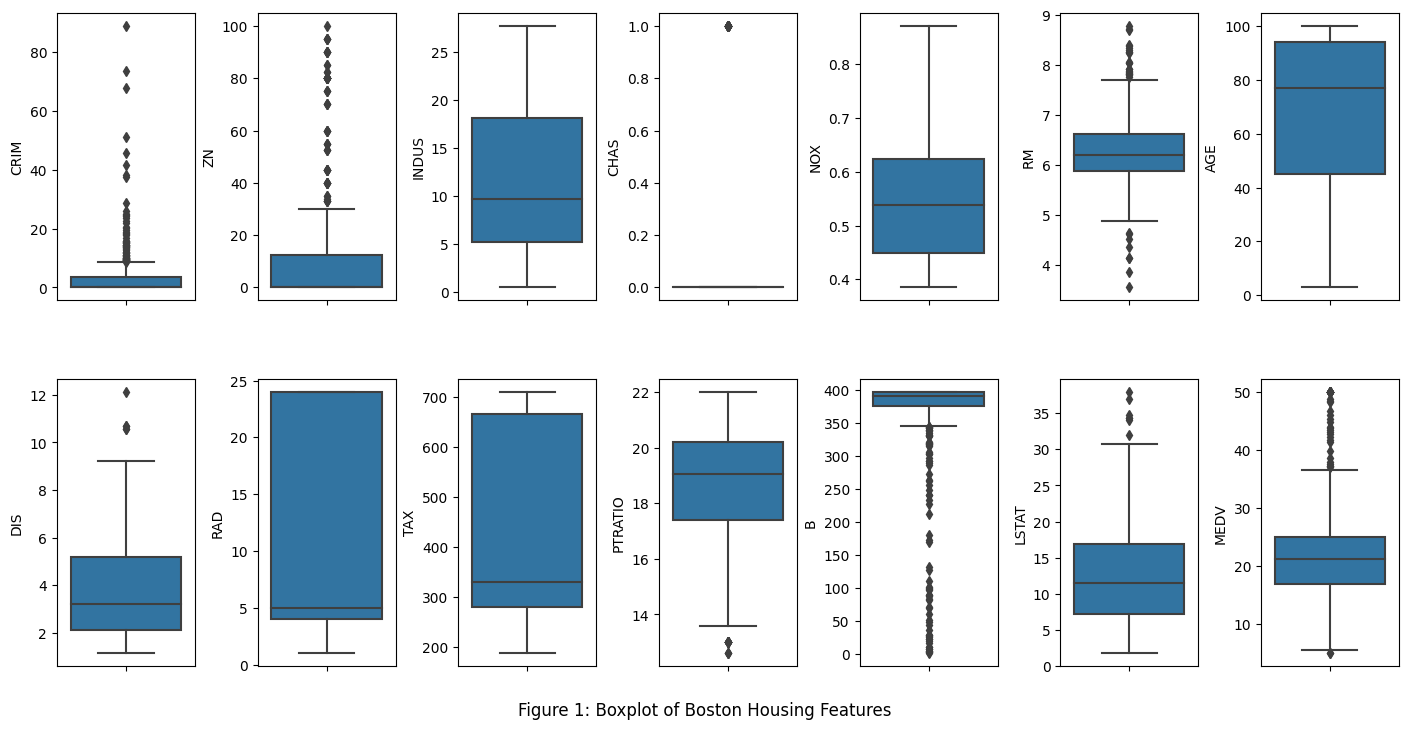

In [5]:
eda_plot(data = boston, title = 'Figure 1: Boxplot of Boston Housing Features', option = "box")

According to the Figure 1 above, we can observe that several columns in the Boston dataset such as `CRIM`, `ZN`, `RM`, and `B` appear to have many outliers. In the context of machine learning, extreme outliers can be problematic because they can skew statistical measures such as mean and standard deviation. 

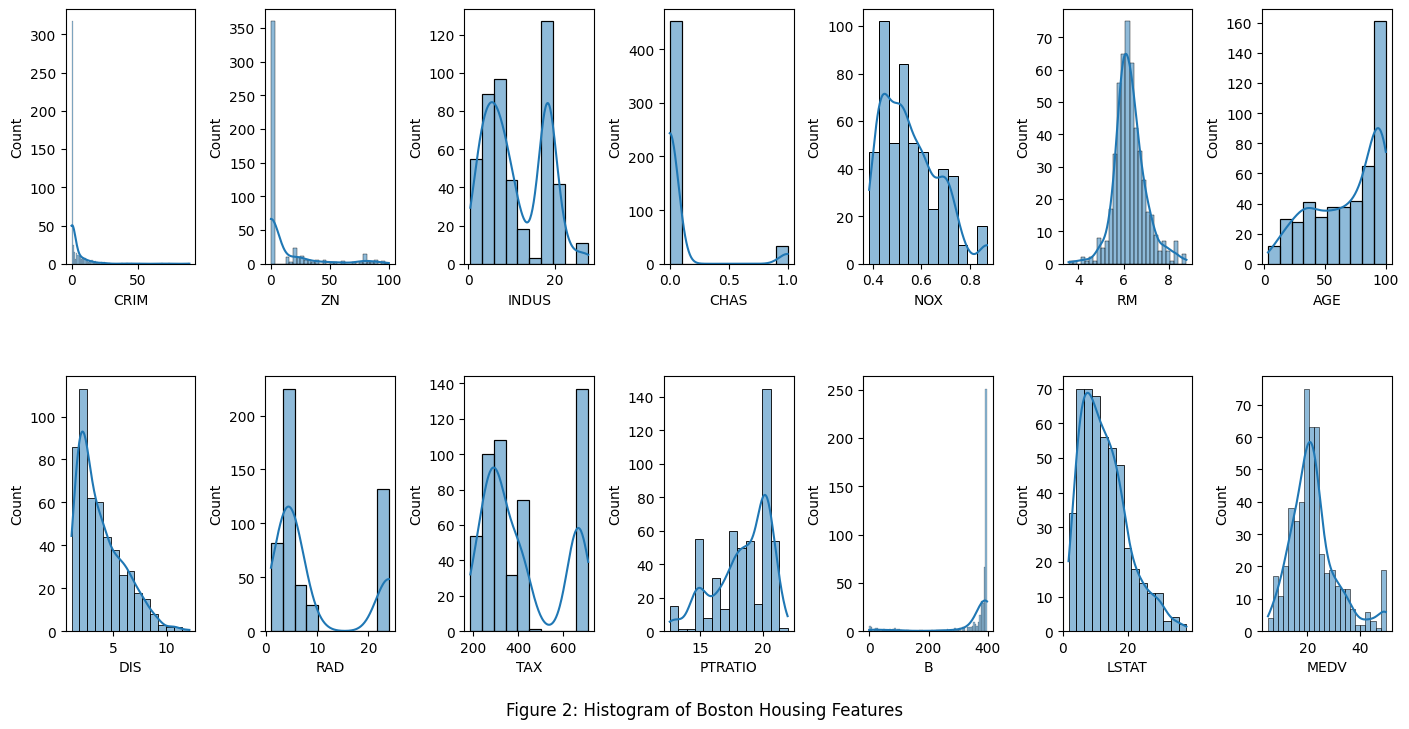

In [6]:
eda_plot(data = boston, title = 'Figure 2: Histogram of Boston Housing Features', option = "hist")

In addition to identifying outliers, it is also important to understand the distributions of the individual columns in the dataset. The histograms generated earlier from Figure 2 suggest that columns `CRIM`, `ZN`, `LSTAT`, `DIS` and `B` have skewed distributions. 
The distributions of the other columns appear to be normal or bimodal, except for `CHAS`, which is a discrete variable.
In contrast, the histogram of `MEDV` (the variable we are trying to predict) appears to have a roughly normal distribution.

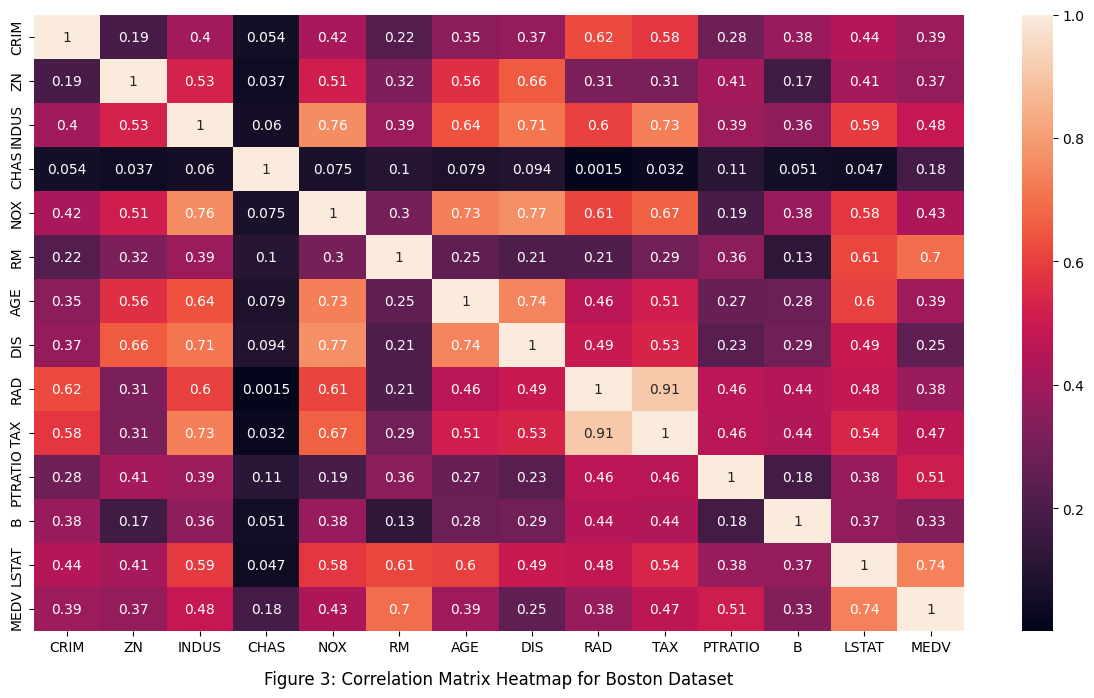

In [7]:
# Note we took absolute value of the correlation coefficients here
eda_plot(data = boston, title = 'Figure 3: Correlation Matrix Heatmap for Boston Dataset', option = "heatmap")

Based on Figure 3 above, we can observe that several independent variables exhibit a strong correlation with the target variable, `MEDV`. All the correlations are positive as we consider the absolute value of the correlations, to notice correlations easier. The color scale represents the strength of the correlation, with lighter colors indicating stronger correlations.

Specifically, the variable `RM` exhibits a correlation coefficient of $0.7$ with `MEDV`, while `LSTAT` exhibits a correlation coefficient of $0.74$ with `MEDV`. These correlations are relatively high compared to the other variables, and suggest that `RM` and `LSTAT` may be useful predictors for our regression model.

However, it is also important to note that the variable `TAX` exhibits a strong correlation with the variable `RAD`, with a correlation coefficient of $0.91$. This suggests the presence of multicollinearity, which can cause issues in regression analysis such as inflated standard errors, reduced statistical power, and unstable coefficients. Therefore, it may be necessary to address multicollinearity in the modelling process, perhaps deleting one of the predictors.

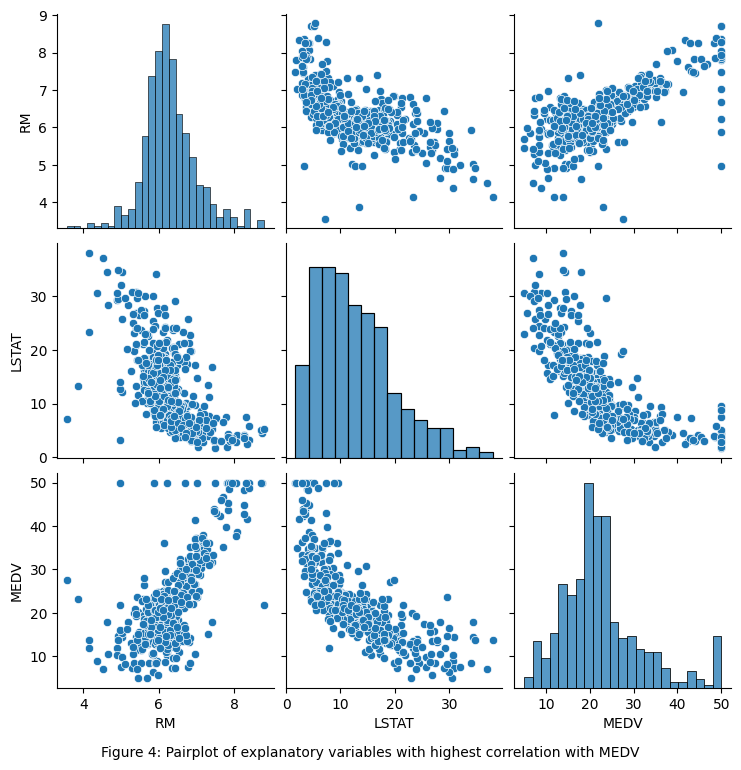

In [8]:
# Plot those correlation plots of independent variables with highest
# correlation with the dependent ("MEDV")
higest_correlations = ["RM", "LSTAT", "MEDV"]
bos_df_univariate = boston[higest_correlations]
pair_plot = sns.pairplot(bos_df_univariate)
pair_plot.fig.suptitle("Figure 4: Pairplot of explanatory variables with highest correlation with MEDV", 
                       y=-0.001, fontsize=10)
plt.show()

Based on Figure 4, we selected two variables, `RM` and `LSTAT`, which have the strongest linear relationships with `MEDV`, to generate the pair plot. The scatter plot of `MEDV` v.s. `RM` shows a strong positive correlation, while the scatter plot of `MEDV` v.s. `LSTAT` shows a strong negative correlation.
In the scatter plot of `MEDV` v.s. `RM`, we noticed that the range of `MEDV` seemed to be limited to 0-50k, with many extreme values equal to 50k. This may suggest that during the data collection process, the collectors only gathered housing data below 50k, or that outliers greater than 50k were uniformly recorded as 50k.

Although `both` RM and `LSTAT` could be powerful predictors, we also observed a strong linear relationship between `LSTAT` and `RM`, which could pose a risk of multicollinearity if both variables are included in the regression model. Further analysis is required to determine the most appropriate set of predictors to include in the final model.


### Model Fitting

In the model fitting phase, we will split the Boston Housing dataset into training and testing sets. We will then use the training set to select the relevant variables and build our final multiple linear regression model. The selection process can involve various techniques, such as stepwise regression or regularization, depending on the specific requirements of the project. Once we have the final model, we will use the testing set to evaluate its performance in terms of Root Mean Squared Error (`RMSE`). The goal is to ensure that the model can generalize well to new, unseen data and make accurate predictions. 

To further explore effects of using different methods of regression, we are going to fit multiple models to using similar metrics across these to compare best fit of model, i.e. , Mean Absolute Error (`MAE`), `RMSE`, Mean Squared Error (`MSE`) for prediction purposes models. Our ideal approach to test this is to fit the following models:
1. Ordinary Least Squares (OLS) as baseline 
2. OLS with L1-norm regularization (Least Absolute Shrinkage and Selection Operator (LASSO) Regression)
3. Random Forest (RF) Regression

In order to compare different machine learning models, we will use the same scoring metrics (defined below) across all models. We will first perform a raw fit to all models to see how they perform against the test set. This step will give us a baseline performance of each model before applying any preprocessing or hyperparameter optimization.

Next, we will apply common preprocessing steps to all models, such as scaling and imputation on missing values by median value given we had quite a lot of skewed distributions. After applying the preprocessing steps, we will optimize the hyperparameters for each model using 5-fold cross-validation. This step will help us identify the best combination of hyperparameters for each model.

Finally, we will compare the performance of all models again against the test set by using the same scoring metrics. This comparison will help us identify the most suitable model for our prediction problem.

##### Load and Split data

To begin, we will split the data into train and test data for further modelling purposes. The training set will be used to train the three models and find the best hyperparameters. The testing set will be used to evaluate each model's performance on previously unseen data, which helps us to assess models' ability to generalize beyond the training set.

In [9]:
# use same random_state across all parts to ensure reproducibility
random_state = 20230325

# Splits the data into X and y train and test portions
X_train, X_test, y_train, y_test = split_data(data_path, 
                                              proportion = 0.75, 
                                              target = "MEDV", 
                                              random_state=random_state)

##### Fit all to preview

Moreover, we are going to use common scoring metrics (as mentioned earlier) across all models, so that we could compare their effectiveness in prediction:

In [10]:
# define common scoring across models (below is for scikit-learn)
scoring = {
    "neg_mae": "neg_mean_absolute_error",
    "neg_rmse": "neg_root_mean_squared_error",
    "neg_mse": "neg_mean_squared_error"
}

We could fit all the previous models mentioned at once and perform cross validation in a more rapid way to compare and check which might perform better at **predicting house prices**.
Then we could fit the methods individually in sections below raw, then with preprocessing, and check if getting similar scores like these CVs.

In [11]:
# # fit all models at once to decide which one to use
# # User-defined scoring to be hanlde in-terms of calculating scores for model
# # Note scikit learn implemented these scorings in negative scale to minimize loss
# # which we will scale back to positive behind the scenes

def fit_all(scoring=scoring, **kwargs):
    methods = ["OLS", "LASSO", "Random Forest"]
    models = [mod for mod in [LinearRegression(), Lasso(), RandomForestRegressor()]]
    # allocate space to store model fitted outputss
    result_dict = {}
    # fit all of these models at once
    for method, model in zip(methods, models):
        result_dict[method] = mean_std_cross_val_scores(model, 
                                                       X_train, 
                                                       y_train, 
                                                       return_train_score=True,
                                                       scoring=scoring
                                                     )
    
    result = pd.DataFrame(result_dict)
    # rename the index to positive scale for easier comparison, replace the neg by empty
    return result.rename(lambda x: x.replace("_neg", ""))
all_cv = fit_all(X_train=X_train, y_train=y_train)
all_cv.style.set_caption("Means CVs and +- std for Regression Methods")

,OLS,LASSO,Random Forest
fit_time,0.001 (+/- 0.001),0.001 (+/- 0.001),0.208 (+/- 0.058)
score_time,0.002 (+/- 0.004),0.001 (+/- 0.001),0.005 (+/- 0.002)
test_mae,3.124 (+/- 0.397),3.527 (+/- 0.280),2.298 (+/- 0.168)
train_mae,2.930 (+/- 0.125),3.402 (+/- 0.105),0.845 (+/- 0.025)
test_rmse,4.520 (+/- 0.788),5.003 (+/- 0.585),3.428 (+/- 0.523)
train_rmse,4.278 (+/- 0.197),4.858 (+/- 0.167),1.300 (+/- 0.144)
test_mse,20.925 (+/- 7.115),25.308 (+/- 5.804),11.972 (+/- 3.448)
train_mse,18.329 (+/- 1.684),23.627 (+/- 1.630),1.708 (+/- 0.381)


From the above table, we could see fit time, score time, and the scoring metrics we set earlier **(MAE, RMSE, MSE)**. Each entry is the mean cross-validation (cv) scores $\pm$ its standard deviation. 

Based on the test scores, the RF model performs the best, this is expected since trees could capture non-linear relationships (if existed) between variables. Also, it trains multiple decision trees simultaneously and reduces variance through bagging or bootstrap over random subsets of variables and observations.  

For linear models, we observed that plain OLS performs better than LASSO. This could be due to the fact that we only used the default value for the regularization parameter $\alpha$ in LASSO, which might not have selected enough variables. Furthermore, OLS by definition minimizes the prediction error, which is why it outperforms LASSO with default parameters.

For more information, we could also look at training scores, the RF model has the lowest **train** score, which is also expected, since trees are tended to overfit if we set the depth to infinity or if not constrained. However, it takes longer fitting time due to its nature of bagging an ensemble of multiple regression trees. 

Based on the preliminary cv scores, we might have some sense of which models might work better for predicting housing prices in Boston. We hypothesize that RF might be the best model, and OLS would serve as our baseline model to compare. Moving forward, we will fit all models on both raw and preprocessed data to determine the best model for predicting housing prices in Boston. Of course, OLS would serve as our baseline model to compare. 


#### Ordinary Least Squares (OLS)

In the first stage of modelling, we will apply the traditional hedonic ordinary least squares regression to determine the coefficients between housing characteristics and housing prices. With the OLS approach, we can estimate the impact of each attribute on the market value of a heterogeneous good, and then we estimate prices in the form of willingness to pay for one unit of change of that characteristic.

Now, we are going to fit a plain OLS regression model to act as our baseline model for comparing with other regression methods and see their improvements or weakness when applying regularization or boosting and bootstrapping. We propose a mixed model with different exponents for the explanatory variables as the following form:

$$P = \beta_0 + \beta_1 \text{CRIM} + \beta_2 \text{ZN} +\beta_3 \text{INDUS}+\beta_4 \text{CHAS}+\beta_5 \text{NOX}+\beta_6 \text{RM}+ \newline
\beta_7 \text{AGE}+\beta_8 \text{DIS}+\beta_9 \text{RAD}+\beta_{10} \text{TAX}+\beta_{11} \text{PTRATIO}+\beta_{12} \text{B}+\beta_{13} \text{LSTAT} + \epsilon
$$


Whereas $P$ is the target variable: Median price of housing unit in Boston, and other $\beta_i$ are beta estimates of independent variables $x_i\quad \forall i \in [0, 13]$. The $\beta_0$ is an intercept, which is the value of estimated $P$, setting all the independent variables equal to 0. The $\epsilon$ is a term that represents the random error of the model.

In [12]:
# call custom helper to fit OLS model and predict on test data, based on selected metrics
raw_lr = fit_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, name="OLS")
# preprocess train and use that to train model and predict on test
lr_tuned = fit_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, name="OLS", preprocess=True)
# merge results and show it
lr_mods = merge_data(raw_lr, lr_tuned)
lr_mods

,MAE,RMSE,MSE
OLS,3.597,4.954,24.539
OLS + preprocessed,3.468,4.922,24.224


We used three evaluation metrics for our models: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Squared Error (MSE), whereas the lower error is better.

MAE represents the average absolute difference between the predicted and actual values, measuring the average of the residuals. These metrics are commonly used in regression analysis to assess the performance of models. RMSE is the square root of MSE, which measures the standard deviation of residuals between the predicted and actual values. It is also on the same scale as the dependent variable, making it easier to interpret. MSE is the average of the squared difference between the predicted and actual values, measuring the variance of the residuals. 

The preprocessing here mainly refers to imputation and scaling (check the [handle_data.py](https://github.com/tonyliang19/econ323_final_project/blob/main/src/handle_data.py) for details). A good preprocessing can effectively reduce noise, improve consistency, and ensure that all predictors are on the same scale. We can see that these three metrics of "OLS + preprocessed" model are slightly lower than those of the "OLS" model, which means the "OLS + preprocessed" model may have better predictive performance.


#### LASSO Regression

<!----
## DELETE THIS LATER OR ADD IT to LASSO
By nature of LASSO, it is a biased method, since we added regularization penalty to OLS(which is known to be unbiased).

OLS is unbiased by the following:
$$ Y = \beta X + \epsilon, \text{where} \enspace E(\epsilon) = 0 \newline
   E(\beta) = E[(X^{T}X)^{-1}X^{T}Y] \newline
   = E[(X^{T}X)^{-1}X^{T}(\beta X + \epsilon)]\newline
   = (X^{T}X)^{-1}X^{T}X E[\beta] + (X^{T}X)^{-1}X^{T}X E[\epsilon]] \newline
   = I \beta + 0 \newline
   = \beta
$$

By definition in statistics, $\text{MSE}(\hat{\beta})= \text{Var}(\hat{\beta}) + \text{Bias}(\hat{\beta})^{2}$

And OLS is unbiased estimator, hence its MSE is only $\text{Var}(\hat{\beta})$ 

While in LASSO we solve the betas with:
$$ \hat{\beta}^{\text{lasso}} = \underset{\beta \in R^p}{\text{argmin}} \enspace \vert\vert y - X\beta\vert\vert_2^{2} + \alpha \sum\limits_{j=1}^{p} \vert \beta_{j} \vert \newline
   =  \underset{\beta \in R^p}{\text{argmin}} \enspace \vert\vert y - X\beta\vert\vert_2^{2} + \alpha \vert\vert \beta \vert\vert_1
$$

where $\alpha$ is our tuning parameter to control regularization strength of L1 norm, where as $\hat{\beta}^{\text{lasso}} =$ plain OLS, when $\alpha = 0$, and $\hat{\beta}^{\text{lasso}} = 0$ when $\alpha = \infty$. 

Moreover, theres no close form solution for bias and variance (with true model being linear), but there's extra portion from the penalty of $\alpha \vert\vert \beta \vert\vert_{1}$, hence it is a biased estimator. But based on the property of $\alpha$, it is easy to infer the following:

1. High Bias & Low Variance as $\alpha \approx \infty$
2. Low Bias & High Variance $\alpha \approx 0 $
----->

Least Absolute Shrinkage and Selection Operator (LASSO) is a regularization technique to shrink estimated coefficients of OLS like the following:
$$ \hat{\beta}^{\text{lasso}} = \underset{\beta \in R^p}{\text{argmin}} \enspace \vert\vert y - X\beta\vert\vert_2^{2} + \alpha \sum\limits_{j=1}^{p} \vert \beta_{j} \vert \newline
   =  \underset{\beta \in R^p}{\text{argmin}} \enspace \vert\vert y - X\beta\vert\vert_2^{2} + \alpha \vert\vert \beta \vert\vert_1
$$

The $\alpha$ is our tuning parameter to control regularization strength of $L1$ norm, where as $\hat{\beta}^{\text{lasso}} =$ plain OLS, when $\alpha = 0$, and $\hat{\beta}^{\text{lasso}} = 0$ when $\alpha = \infty$. This means that we could effectively select a subset of relevant variables for our housing price prediction model for choosing a larger $\alpha$ as coefficients could shrink to 0. And based on the property of  $\alpha$, it is easy to infer the following:

1. High Bias & Low Variance as $\alpha \approx \infty$
2. Low Bias & High Variance $\alpha \approx 0 $

Therefore, we might need to choose a right $\alpha$ to achieve optimal predictive power of the model. Similar to above OLS, we'll use the LASSO regression with default alpha ($\alpha = 1$) to check the performance by calculating its MAE, RMSE, and MSE, then perform hyperparameter optimization.

In [13]:
# call custom helper to fit LASSO model and predict on test data, based on selected metrics
raw_lasso = fit_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, name="LASSO")
# preprocess train and use that to train model and predict on test
lasso_tuned = fit_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, name="LASSO", preprocess=True)
# merge results and show it
lasso_mods = merge_data(raw_lasso, lasso_tuned)
lasso_mods

,MAE,RMSE,MSE
LASSO,4.300,6.407,41.048
LASSO + preprocessed,4.285,6.155,37.888


After fitting a LASSO regression with default $\alpha = 1$, we obtained MAE, RMSE, MSE of "LASSO" and "LASSO + preprocessed". Compared to the baseline OLS regression earlier, all of these metrics are significantly higher. In particular, the MSE of $41.048$ for the LASSO regression is substantially higher than the MSE of $24.539$ for the OLS regression.

There are some potential reasons that why the LASSO regression is performing worse than the OLS regression. Firstly, the LASSO regression is known to have a higher bias than OLS regression due to its feature selection process, which could lead to an underfitting of the data. It's also possible that the hyperparameter($\alpha$) was not tuned optimally here, which results in suboptimal results.

Overall, while the LASSO regression may have some advantages in terms of feature selection and interpretability, it's clear that it's not always the best choice for every dataset. In this case, the OLS regression appears to perform better and may be a more suitable choice for this particular problem.


#### Random Forest

Consider that traditional linear models may not be able to capture the complex interactions between those factors or handle high-dimensional data, we introduced the RF model. This tree model constructs multiple decision trees based on random subsets of the data and features, and then combines the predictions of these trees to make a final prediction. This approach is particularly well-suited for modelling the relationships between a large number of housing attributes and housing prices. Our RF model has been trained using 12 predictor variables and employs 100 trees with 3 randomly selected predictor variables at each split. The default number of trees in the RF model is 100. Meanwhile, the default number of features to consider when looking for the best split is the square root of the number of features, which is 3 in this case.


In [14]:
# call custom helper to fit Random Forest model and predict on test data, based on selected metrics
raw_rf = fit_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, name="RF",
                   random_state=random_state)
# preprocess train and use that to train model and predict on test
rf_tuned = fit_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, name="RF", 
                     preprocess=True, random_state=random_state)
# merge results and show it
rf_mods = merge_data(raw_rf, rf_tuned)
rf_mods

,MAE,RMSE,MSE
Random Forest,2.580,3.619,13.096
Random Forest + preprocessed,2.607,3.693,13.636


The first model, "Random Forest", is trained on the raw data without any preprocessing. Averaging across all 100 trees, the MAE, RMSE, and MSE for this model are $2.580$, $3.619$, and $13.096$, respectively. 
The second model, "Random Forest + preprocessed," is trained on preprocessed data, indicating that some data preprocessing steps have been applied to the training data before fitting the model. The MAE, RMSE, and  MSE for this model are $2.607$, $3.693$, and $13.636$ respectively.
We can see that the models with and without preprocessing do not have significant differences in terms of these three metrics. Hence, we could hypothesize scaling/imputing is not required for RF models. Moreover, RF models showed relatively lower scores for the different metrics compared to the OLS and LASSO regression. 

#### Models Summary

Based on the three models we fitted in the previous sections, we summarized the cross-validation scores and test scores into a single table for comparison. These three models are all fitted with the default hyperparameters, so in order to save computing time, we plan to have a glimpse of these scores first and choose a model to perform hyperparameter optimizations later. 

In [15]:
# show all results
all_mods = merge_data(lr_mods, lasso_mods, rf_mods)
# get the mean test cvs scores earlier to compare with the ones with got right now 
cvs = all_cv.loc[["test_mae", "test_rmse", "test_mse"]].rename(lambda x: x.replace("test_", "").upper()).add_suffix("_CV").T
merge_data(cvs, all_mods)

,MAE,RMSE,MSE
OLS_CV,3.124 (+/- 0.397),4.520 (+/- 0.788),20.925 (+/- 7.115)
LASSO_CV,3.527 (+/- 0.280),5.003 (+/- 0.585),25.308 (+/- 5.804)
Random Forest_CV,2.298 (+/- 0.168),3.428 (+/- 0.523),11.972 (+/- 3.448)
OLS,3.597,4.954,24.539
OLS + preprocessed,3.468,4.922,24.224
LASSO,4.3,6.407,41.048
LASSO + preprocessed,4.285,6.155,37.888
Random Forest,2.58,3.619,13.096
Random Forest + preprocessed,2.607,3.693,13.636


By comparing the cross-validation scores, which provides an estimate of the model's generalization ability, to the test scores, which evaluates the model's performance on unseen data, we can evaluate the likelihood of overfitting. Therefore, this table serves as a useful tool in the model selection process, enabling us to select the model with the best balance between accuracy and generalization ability. Overfitting is a common problem in machine learning, where a model learns the training data too well and becomes too specific to that particular dataset. This results in poor performance on unseen data in the real world. For simplicity, the `*_CV` means a mean error $\pm$ its standard deviation of certain metric. 

Here we can see that in terms of MSE, "LASSO_CV" has $25.308$, while the a single test MSE of "LASSO" is $41.048$. The big gap between the cross-validation MSE and testing MSE indicates that there might be overfitting in the LASSO regression model.

Although the RF model shows relatively lower scores for the different metrics compared to the other models, it may not be the most appropriate model for our specific prediction task. Since our main goal is to accurately predict housing prices in Boston with simple terms, it is important to consider not only the predictive performance but also the interpretability of the model. Tree models are known to be complex and difficult to interpret, making it challenging to understand how the model arrived at its predictions.

On the other hand, LASSO regression, with a default alpha value of $1$, may have potential issue of overfitting, as we observed in our previous analysis. We suspect that an optimal alpha value for LASSO should be smaller than $1$ to avoid overfitting. Therefore, we decided to explore the effect of hyperparameter optimization on overfitting by focusing on the LASSO regression model.

### Model Selection

In order to identify the best regularization parameter for the LASSO regression, we performed a grid search across a range of alpha values. We defined a helper function to compute the mean score of 5-fold cross-validation for the three different scoring metrics: MAE, RMSE, and MSE. The range of alpha values was set to $e^x$ for $x \in [-10, 10]$, with $200$ values evenly spaced in between.

After computing the cross-validation scores for each alpha value, we saved the results in a dictionary and then converted it to a pandas dataframe for easier analysis. The dataframe includes the mean cross-validation scores for each alpha value and each scoring metric, as well as the alpha value itself. We then sorted the dataframe by the ascending order of the metrics.

In [16]:
# compute 5 fold cv for a range of values of alpha for LASSO 
alphas_range = np.exp(np.linspace(10, -10, 200))
# helper to manually compute mean of 5-fold cv for the scoring metrics set earlier of LASSO
def optimize_lasso(alphas_range): 
    # try to read pre-trained table to save computation time
    path_out = "data/lasso_alphas.csv"
    try: 
        out = pd.read_csv(path_out, index_col=0)
        print(f"Loaded from pre-train at {path_out}")
        return out
    except:
        print("Performing cross-validation now!")
        # pre-allocate space to save metrics
        metrics = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_squared_error']
        result = {metric: [] for metric in metrics}
        grids = {metric: alphas_range for metric in metrics}

        # re-split data to use the dropped NA data by imputing them by median value in the preprocessor
        # Splits the data into X and y train and test portions
        X_train, X_test, y_train, y_test = split_data(data_path, 
                                                      proportion = 0.75, 
                                                      target = "MEDV", 
                                                      random_state=random_state,
                                                      drop_na = False)
        # preprocess data and drop RAD variable because it is indexing variable
        preprocessor = preprocess_data(X_train, drop="RAD")
        # loop through metric and range of alphas and cv
        for metric, alphas in grids.items():
            for a in alphas:
                mod = make_pipeline(preprocessor, Lasso(alpha=a))
                cv_result = cross_val_score(mod, X_train, y_train, cv=5, scoring=metric)
                result[metric].append(-1 * cv_result.mean())
        result["alpha"] = alphas_range
        # save output to dataframe and rename necessary columns, then sort by ascending order of root mean squared error
        out = pd.DataFrame(result).rename(columns=lambda s: s.replace("neg_", "")).sort_values(by=["mean_absolute_error", "root_mean_squared_error", "mean_squared_error"])
        out.to_csv(path_out)
        print(f"Done! The results would be saved to {path_out}")
        return out
lasso_alphas = optimize_lasso(alphas_range = alphas_range)
lasso_alphas

Loaded from pre-train at data/lasso_alphas.csv


,mean_absolute_error,root_mean_squared_error,mean_squared_error,alpha
121,3.445261,4.905642,24.777012,0.115232
122,3.445286,4.902632,24.740217,0.104214
123,3.445418,4.900260,24.710330,0.094250
124,3.445752,4.898411,24.686161,0.085238
120,3.445965,4.909468,24.822543,0.127416
...,...,...,...,...
75,6.917753,9.348936,88.944097,11.731899
76,6.917753,9.348936,88.944097,10.610128
77,6.917753,9.348936,88.944097,9.595618
78,6.917753,9.348936,88.944097,8.678112


From the above table, it seems that the smaller values of alpha tend to yield better prediction estimates. However, this implies that we are not excluding any irrelevant variables if we select an optimal alpha value. Therefore, we could select an alpha value that is sufficiently large to capture important variables and maintaining relatively low prediction error.

To achieve this, we can filter the table to select a value from one of MAE, RMSE, and MSE that are below a determined threshold and then select a larger alpha from the filtered results. This approach will not only incorporate important variables but also prevent overfitting, resulting in a more interpretable and simpler model. By the nature of measurements of our metrics, we will look at RMSE specifically, since it measures the standard deviations of our prediction errors, and it's on the same scale of the housing price that we are predicting.

Moreover, we could visualize these scoring metrics by their correspondent alpha value to get a sense on how the error decrease/increase by changing the tuning parameter.

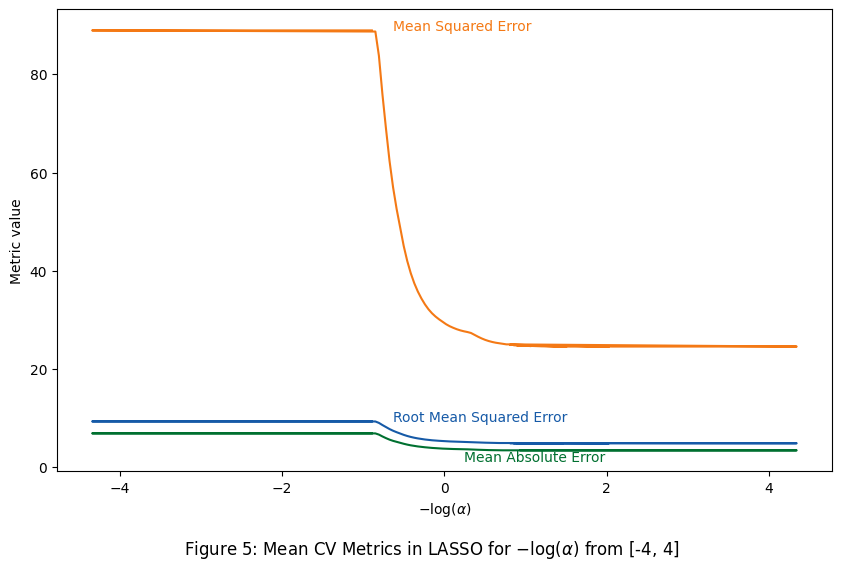

In [17]:
# replace the X here with the right number of fig num
plot_alpha_metrics(title="Figure 5: Mean CV Metrics in LASSO for " + r"$-\log(\alpha)$" + " from [-4, 4]", data=lasso_alphas)

To visualize the above plot easier, we transformed the domain of $\alpha$ to $-log(\alpha)$ on our x-axis. Although there were some wiggly movements of the metric value, but we were still able to notice a trend on where lower errors are located at. In particular, it decreases from $-log(\alpha) = 1$ $-log(\alpha) = 4$, which is equivalent to its inverse of $\alpha = e^{-4} = 0.018$ to $\alpha = e^{-1} = 0.368$ or $\alpha \in [0.018, 0.368]$ achieves the lower errors. Note, this $\alpha$ range is quite small scale, so we might need further exploration on the table to find $\alpha$ that penalize more on coefficients and achieve variable selection.

In [18]:
# print optima alpha by lowest rmse
lowest_rmse = lasso_alphas.head(1)
lowest_rmse

,mean_absolute_error,root_mean_squared_error,mean_squared_error,alpha
121,3.445261,4.905642,24.777012,0.115232


Given the optimal alpha is near $0.115$, which gives a RMSE of approximately $4.906$. We can examine other alpha values that yields similar or close RMSE but with a larger alpha value. Therefore, we set a threshold RMSE value of $6$ and filter for alpha values that score RMSE values below this threshold.  

In [19]:
# change the values here to query a differently
rmse = 6
# query by changing rmse to threshold above and sorted it descending alpha
larger_alpha_rmse = lasso_alphas.query(f"root_mean_squared_error < {rmse}").sort_values(by="alpha", ascending=False).reset_index().drop(columns=["index"])
larger_alpha_rmse.head(3)

,mean_absolute_error,root_mean_squared_error,mean_squared_error,alpha
0,4.250367,5.885475,35.780516,2.124994
1,4.162211,5.768916,34.382187,1.921808
2,4.082827,5.666354,33.179315,1.738050


Based on the above table, the resulting values are then sorted in descending order by alpha value. The first three values in the resulting table are displayed. The MAE, RMSE, and MSE values for these alpha values are slightly higher than those for the LASSO model with optimal alpha. However, by increasing the alpha value from $0.078$ to $2.125$, we are able to increase the level of penalization and drop more variables, which means we can get a simpler model that still has an acceptable level of prediction accuracy.

Then, we use the biggest alpha in the above alphas to fit our final lasso model and see how the lasso selects variables. 

In [20]:
# choose the alpha for lasso
selected_alpha = larger_alpha_rmse["alpha"][1]
# helper to return selected variables from LASSO regression by input alpha
def selected_variable(selected_alpha):
    # fit to lasso with preprocessor (scale numeric data, and drop columns)
    preprocessor = preprocess_data(X_train, drop="RAD")
    pipe_lasso = make_pipeline(preprocessor, Lasso(alpha=selected_alpha))
    pipe_lasso.fit(X_train, y_train)
    # get coefficients and column names
    coefs = pipe_lasso.named_steps["lasso"].coef_
    names = pipe_lasso.named_steps["columntransformer"].transformers[0][2]
    # merge to dataframe and return non zero coefficients only (these are the actual selected ones)
    out = pd.DataFrame(coefs, index=names, columns=["coefficients"]).query("coefficients != 0")
    return out

lasso_coeffs = selected_variable(selected_alpha)
lasso_coeffs

,coefficients
RM,1.655419
PTRATIO,-0.585176
LSTAT,-3.257104


Based on above table `lasso_coeffs`, it shows that the variables `RM`, `PTRATIO`, and `LSTAT` were selected by the LASSO model, as they have non-zero coefficients. Then, we are going to train it with a plain linear regression and report its prediction error on the test set. However, before that, we have to re-split data with these selected variables only to avoid post-selection inference problem.

After selecting the three most important features using LASSO regression, we fit an OLS model with these features to explore whether it performs better than the original OLS model. This approach allows us to simplify the model by including only the most relevant predictors, which may potentially improve the interpretability and reducing overfitting. We can then compare the performance of this model to the original one in terms of key metrics such as MAE, RMSE, and MSE to determine whether the LASSO-selected features improve the accuracy of our predictions.

In [21]:
# new split
chosen_cols = lasso_coeffs.index.to_list()
X_train_new, X_test_new, y_train_new, y_test_new = split_data(data_path=data_path, target="MEDV", chosen_cols=chosen_cols, plain=False)

To visualize the performance of the OLS model, we will use the `visualize_lr` helper function to produce a pair plot of the chosen variables against the target variable, `MEDV`. The plot will display a regression line along with scatter plots that show the relationship between the predictor variables and our target.

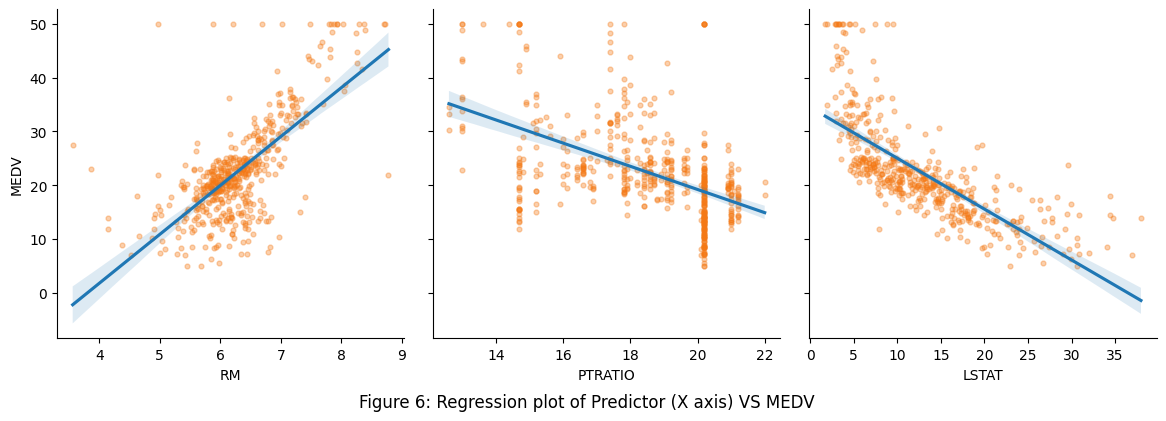

In [22]:
visualize_lr(df=boston, chosen_cols = chosen_cols, title = "Figure 6: Regression plot of Predictor (X axis) VS MEDV", 
             option="subset")

Recall that RM represents average number of rooms, MEDV represents median value of housing price;  LSTAT represents lower status of the population and PTRATIO represents pupil-teacher ratio by town. Then from above plot, we could tell that each predictor variable (X-axis) could still have roughly good fit to the dependent variable (Y-axis) even when they are the only predictor, specifically LSTAT is quite well fitted. Hence, this plot proves that the chosen variables from LASSO is quite close to the true model. Then, we could proceed to compare its scores with the plain OLS.

In [23]:
optimal_model = fit_model(X_train=X_train_new, y_train = y_train_new, X_test = X_test_new, y_test = y_test_new, name="OLS", preprocess=True).rename(index={"OLS + preprocessed": "Optimal OLS"})
merge_data(lr_mods, optimal_model)

,MAE,RMSE,MSE
OLS,3.597,4.954,24.539
OLS + preprocessed,3.468,4.922,24.224
Optimal OLS,3.459,5.080,25.804


In the presented table, the Optimal OLS is the regression model with the features selected by post-lasso. We can see that the Optimal OLS has a lower MAE compared to the other two models, but the RMSE and MSE increased slightly. Although the Optimal OLS model has a higher RMSE and MSE than the original OLS model, it successfully reduces the number of predictors from $13$ to $3$. The slight sacrifice in model performance is acceptable here considering the reduction in complexity. The Optimal OLS model helps us to simplify the model and improve interpretability. Thus, the Optimal OLS model with three predictors could be a better choice for practical use.

## Conclusion

For comparison, we are going to refit the OLS model without any preprocessing and compare the coefficients with the Optimal OLS model. 

In [24]:
# This is the original
ols_coefficients(X_train, y_train)

,linreg
(Intercept),38.811
CRIM,-0.110
ZN,0.053
INDUS,0.060
CHAS,2.984
NOX,-20.390
RM,3.191
AGE,0.004
DIS,-1.364
RAD,0.349


The fitted OLS model can be represented as below:

$$P^{plain} = 38.811 -0.110 \cdot \text{CRIM} + 0.053 \cdot \text{ZN} +0.060 \cdot\text{INDUS} + 2.984 \cdot \text{CHAS} \newline 
-20.390\cdot \text{NOX}+3.191\cdot \text{RM}+0.004 \cdot\text{AGE}+1.364 \cdot\text{DIS} +0.349 \cdot\text{RAD} \newline
- 0.016\cdot \text{TAX} - 0.816 \cdot\text{PTRATIO}+0.008\cdot \text{B}-0.475\cdot \text{LSTAT} + \epsilon$$

whereas $P^{plain}$ is the target variable: Price of housing in Boston, where $plain$ denotes from plain OLS. The $\epsilon$ represents the random error of the model.

The OLS model with all $13$ predictors can be challenging to interpret, especially in real-world applications where we aim to make predictions for new data points. Meanwhile, including irrelevant predictors can increase the model's complexity and make it challenging to understand the relationships between the predictors and the target variable. Therefore, in practice, it is often preferred to use a model with a limited number of relevant predictors to enhance the model's interpretability and predictive accuracy. 

In [25]:
# This is the optimal one
ols_coefficients(X_train_new, y_train_new)

,linreg
(Intercept),16.298
RM,4.959
PTRATIO,-1.024
LSTAT,-0.475


The fitted Optimal OLS model can be represented as below:

$$P^{postlasso} = 16.298 + 4.959\cdot \text{RM} -1.024 \cdot\text{PTRATIO} -0.475\cdot \text{LSTAT} + \epsilon$$

whereas $P^{postlasso}$ is the target variable: Price of housing in Boston, where $postlasso$ denote OLS post LASSO. The $\epsilon$ represents the random error of the model. Recall the meaning of these variables:
- `RM` - average number of rooms per dwelling
- `PTRATIO` - pupil-teacher ratio by town
- `LSTAT` - $%$ lower status of the population

Then, we could interpret the model as the following: 

Fixing all predictors to constant, i.e. `RM`, `PTRATIO`, `LSTAT` to $0$, then the median price of housing is $16.298$ thousands of dollars, given our RMSE was $5.080$, this value is quite close to the sample we had from our EDA section. Now if we consider the effects of the predictors, then we have the following interpretations:

When the number of rooms per dwelling increases by one unit, the median price of housing tends to increase by $4.959$ thousand dollars. Conversely, when the pupil-teacher ratio by town increases by one unit, the median price of housing tends to decrease by $1.024$ thousand dollars. Similarly, when the percentage of the lower status of the population increases by one unit, the median price of housing tends to decrease by $0.475$ thousand dollars. These coefficients are intuitive and meet our expectations, as the number of rooms in a house is a direct factor affecting its price, and the education environment and socioeconomic status of the neighborhood can also significantly impact the value of a property.

We can clearly see that the Optimal OLS model is much straightforward and easier to interpret compared to the original OLS model. In this context, the Optimal OLS model with three predictors selected by LASSO regression can provide a simpler and more interpretable model than the OLS model with all 13 predictors.

Based on our interpretations, we can conclude that the final Optimal OLS model with three predictors, including `RM`, `PTRATIO`, and `LSTAT`, is a simple yet powerful model to predict the housing prices in the Boston area.

## Discussion 

However, the limitations of this model should be acknowledged. Firstly, the dataset is from the 1970s, and the housing market has changed significantly since then in Boston. As a result, this model may not be applicable in the current housing market, as there are likely to have additional factors affecting housing prices that were not included in the dataset. Therefore, when using this model to predict housing prices, we should consider these limitations as well. To improve this model, we could consider collecting more recent data that includes additional variables that may affect housing prices, such as access to public transportation, and proximity to amenities such as grocery stores and restaurants. Additionally, we could explore more advanced machine learning models, such as gradient boosting, to try improving the model's performance significantly compared to linear model.

In the original problem, the Optimal OLS model can be used to predict housing prices based on the three selected predictors. This model provides valuable insights into how different factors can affect housing prices, and it can be useful for individuals or organizations that are interested in investing in real estate in the Boston area. However, as mentioned earlier, the limitations of this model should be considered, and caution should be used when interpreting the results. Nonetheless, working with this dataset has been a great exercise for our Python coding skills.

## References

Vishal, V. (2017, October 27). Boston Housing Dataset. Kaggle. Retrieved March 14, 2023, from https://www.kaggle.com/datasets/altavish/boston-housing-dataset 

Tibshirani, R. (2013, March 21). Modern regression 2: The lasso. Retrieved April 12, 2023, from https://www.stat.cmu.edu/~ryantibs/datamining/lectures/17-modr2.pdf